In [2]:
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC


In [3]:
audio_path = "LJ001-0001.wav"

waveform, sr = torchaudio.load(audio_path)

if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

if sr != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
    waveform = resampler(waveform)
    sr = 16000

signal = waveform.squeeze().numpy()

print("Sample Rate:", sr)
print("Number of Samples:", len(signal))
print("Duration (seconds):", round(len(signal)/sr, 2))


Sample Rate: 16000
Number of Samples: 154481
Duration (seconds): 9.66


In [12]:
pip install phonemizer

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

inputs = processor(signal, sampling_rate=16000, return_tensors="pt").input_values

with torch.no_grad():
    logits = model(inputs).logits

predicted_ids = torch.argmax(logits, dim=-1)

tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids[0])

tokens = [t for t in tokens if t != processor.tokenizer.pad_token]

print("Recognized Phoneme-like Units:")
print(tokens)


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Recognized Phoneme-like Units:
['P', 'R', 'R', 'I', 'N', 'N', 'T', 'T', 'I', 'I', 'N', 'N', 'G', '|', '|', '|', '|', 'I', 'N', '|', '|', 'T', 'T', 'H', 'E', 'E', '|', '|', 'O', 'N', 'L', 'Y', '|', '|', '|', 'S', 'S', 'E', 'E', 'N', 'N', 'S', 'S', 'E', '|', '|', '|', 'W', 'I', 'T', 'H', 'H', '|', 'W', 'H', 'H', 'I', 'I', 'C', 'H', 'H', '|', '|', 'W', 'W', 'E', '|', '|', 'A', 'R', 'E', '|', '|', 'A', 'T', 'T', '|', '|', 'P', 'R', 'R', 'E', 'S', 'E', 'N', 'T', '|', '|', 'C', 'O', 'N', 'N', 'C', 'E', 'R', 'N', 'N', 'E', 'D', '|', '|', '|', 'D', 'I', 'F', 'F', 'E', 'R', 'R', 'R', 'S', 'S', '|', '|', 'F', 'R', 'R', 'O', 'O', 'M', '|', '|', '|', 'M', 'M', 'O', 'S', 'S', 'T', '|', '|', 'I', 'F', '|', '|', '|', 'N', 'N', 'O', 'T', '|', '|', 'F', 'R', 'O', 'M', '|', '|', '|', '|', 'A', 'L', 'L', 'L', '|', '|', '|', '|', 'T', 'H', 'E', '|', '|', 'A', 'R', 'R', 'T', 'S', '|', '|', 'A', 'N', 'D', '|', '|', 'C', 'R', 'R', 'A', 'F', 'F', 'T', 'T', 'T', 'S', 'S', '|', '|', '|', 'R', 'R', 'R', 'E', 'P'

In [5]:
logits = logits.squeeze(0)
ids = predicted_ids.squeeze(0)

tokens = processor.tokenizer.convert_ids_to_tokens(ids)
tokens = [t for t in tokens if t != processor.tokenizer.pad_token]

total_time = len(signal) / sr
steps = logits.shape[0]
time_per_step = total_time / steps

intervals = []

start = 0
current = tokens[0]

for i, t in enumerate(tokens[1:], start=1):
    if t != current:
        intervals.append((current, start * time_per_step, i * time_per_step))
        current = t
        start = i

intervals.append((current, start * time_per_step, len(tokens) * time_per_step))

for p in intervals[:10]:
    print(p)


('P', 0.0, 0.02003125)
('R', 0.02003125, 0.06009375)
('I', 0.06009375, 0.080125)
('N', 0.080125, 0.1201875)
('T', 0.1201875, 0.16025)
('I', 0.16025, 0.2003125)
('N', 0.2003125, 0.240375)
('G', 0.240375, 0.26040625)
('|', 0.26040625, 0.34053125)
('I', 0.34053125, 0.3605625)


In [6]:
label, t_start, t_end = intervals[1]

s_start = int(t_start * sr)
s_end = int(t_end * sr)

phoneme_signal = signal[s_start:s_end]

print("Extracted Phoneme:", label)
print("Duration:", round(t_end - t_start, 4), "seconds")


Extracted Phoneme: R
Duration: 0.0401 seconds


In [7]:
import soundfile as sf

file_name = "phoneme_" + label + ".wav"
sf.write(file_name, phoneme_signal, sr)

print("Saved as:", file_name)


Saved as: phoneme_R.wav


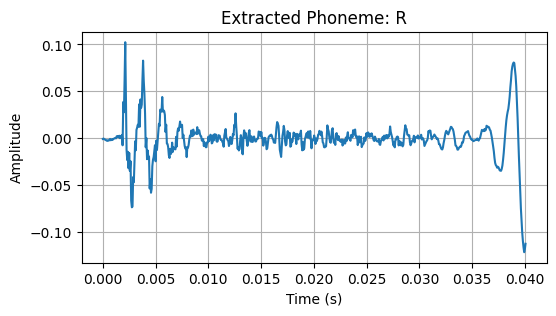

In [8]:
time_ph = np.linspace(0, len(phoneme_signal)/sr, len(phoneme_signal))

plt.figure(figsize=(6,3))
plt.plot(time_ph, phoneme_signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Extracted Phoneme: " + label)
plt.grid()
plt.show()


In [9]:
energy = np.mean(phoneme_signal**2)

zcr = np.mean(np.abs(np.diff(np.sign(phoneme_signal))))

if energy > 0.01 and zcr < 0.1:
    nature = "Voiced"
elif energy < 0.01 and zcr > 0.1:
    nature = "Unvoiced"
else:
    nature = "Mixed"

print("Phoneme:", label)
print("Energy:", round(energy, 4))
print("Zero Crossing Rate:", round(zcr, 4))
print("Nature of Sound:", nature)


Phoneme: R
Energy: 0.0004
Zero Crossing Rate: 0.3938
Nature of Sound: Unvoiced
